### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import requests
import datetime
import pytz
import sqlite3
%matplotlib inline

# Data Source: SQLITE Database

In [2]:
conn = sqlite3.connect('database.sqlite')
command = 'SELECT * FROM BoardGames'
board_games = pd.read_sql(command, conn)

##### After mulling through the data, we thought that an interesting question to answer would be "What number of people should you invite to a party to allow you the broadest access to boardgames in this dataset?" We will take the columns `details.minplayers` and `details.maxplayers` and do some logical analyses at various values to find our answer.

In [3]:
players = board_games[['game.id', 'details.minplayers', 'details.maxplayers']]
players.head()

,game.id,details.minplayers,details.maxplayers
0,1,3.0,5.0
1,2,3.0,4.0
2,3,2.0,4.0
3,4,2.0,4.0
4,5,3.0,6.0


##### When looking at NaN values on our `details.minplayers` series, we find 3 games. It looks like it's missing the corresponding information for the series `details.maxplayers`.

In [4]:
players.loc[players['details.minplayers'].isnull()]

,game.id,details.minplayers,details.maxplayers
40857,53344,NaN,NaN
40954,54165,NaN,NaN
41523,57161,NaN,NaN


##### Let's use the same method, but call the series `details.maxplayers`, just to make sure there aren't any games with values for `details.minplayers` but lack values for `details.maxplayers`.

In [5]:
players.loc[players['details.maxplayers'].isnull()]

,game.id,details.minplayers,details.maxplayers
40857,53344,NaN,NaN
40954,54165,NaN,NaN
41523,57161,NaN,NaN


##### Suprisingly, they correspond perfectly! There are ***NOT*** any values that have one value but lack the other.Since they don't have values in either series, let's drop them and make sure we no longer have any null values.

In [6]:
ids = players.loc[players['details.minplayers'].isnull()].index.values.tolist()
players = players.drop(ids, axis=0)
players['details.minplayers'].isnull().sum()

0

##### Let's see what the maximum amount of players is for any given game to get a sense of how wide our distribution is.

In [7]:
players['details.maxplayers'].max()

11299.0

##### Wow. That's quite a lot of players.

##### Now let's check to make sure we don't have any negative numbers for `details.minplayers`.

In [8]:
players['details.minplayers'].min()

0.0

##### Great! Let's create a series for every bin in our distribution (which, for our purposes, we will limit to 100). We'll use some boolean masking to give us `True` if a game can take that number of players, and `False` if it can't.

In [9]:
for num_players in range(1, 101):
    column_name = 'num_players.' + str(num_players)
    players[column_name] = (players['details.minplayers'] <= num_players) & (players['details.maxplayers'] >= num_players)
players.head()

,game.id,details.minplayers,details.maxplayers,num_players.1,num_players.2,num_players.3,num_players.4,num_players.5,num_players.6,num_players.7,...,num_players.91,num_players.92,num_players.93,num_players.94,num_players.95,num_players.96,num_players.97,num_players.98,num_players.99,num_players.100
0,1,3.0,5.0,False,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,3.0,4.0,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,2.0,4.0,False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,2.0,4.0,False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,3.0,6.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


##### Now that we have those series, we can sum them to create a dataframe that will reflect our distribution, with a series for the `Number of Players`, and `Number of Games`.

In [10]:
counts = players.filter(like='num_players').sum(axis=0).to_frame()
counts['Number of Players'] = [splitted.split('.')[1] for splitted in counts.index.values.tolist()]
counts = counts.rename(columns={0: 'Number of Games'}).reset_index(drop=True)
counts = counts[['Number of Players', 'Number of Games']]
counts = counts.astype(int)
counts.head()

,Number of Players,Number of Games
0,1,10945
1,2,73329
2,3,61442
3,4,61990
4,5,35903


##### This dataframe is hosting our distribution information nicely. Now, when we do a preliminary graph, we can see that the values peak where our number of players is two, and tapers off after that. We're probably safe cutting this graph fairly short to keep it informative and useful.

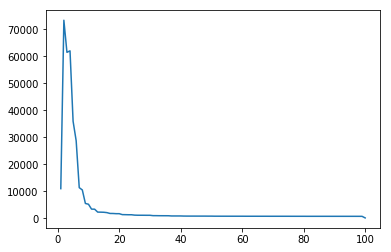

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(counts['Number of Players'].values, counts['Number of Games'].values)
fig;

##### And now, the final product....

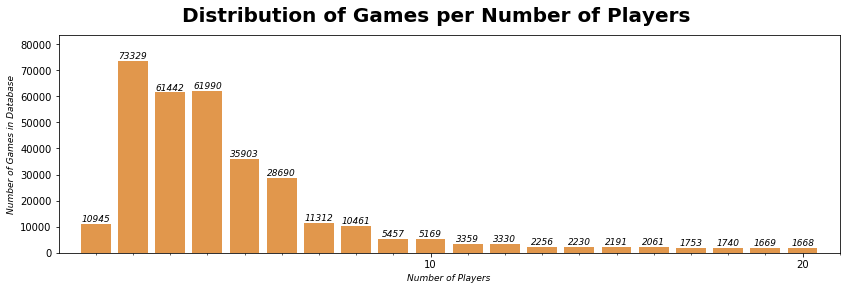

In [12]:
x = counts['Number of Players'].values
y = counts['Number of Games'].values

x_slice = x[:20]
y_slice = y[:20]

text_kwargs = dict(family='sans-serif', fontsize=9, fontstyle='italic')

major_ticker = ticker.FixedLocator([x for x in range(10,max(x)+1,10)])
minor_ticker = ticker.AutoMinorLocator(n=10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 4))
ax.bar(x_slice, y_slice, color='#E1974C')
ax.set_xlim(0, x_slice.max() + 1)
ax.set_ylim(0, y_slice.max() + 10000)
ax.xaxis.set_major_locator(major_ticker)
ax.xaxis.set_minor_locator(minor_ticker)
ax.set_ylabel('Number of Games in Database', **text_kwargs)
ax.set_xlabel('Number of Players', **text_kwargs)

for count in range(0, len(x_slice)):
    ax.text(x=x_slice[count], y=y_slice[count] + 1000, s=str(y_slice[count]), ha='center', **text_kwargs)
    
fig.suptitle('Distribution of Games per Number of Players', fontsize=20, fontweight='bold')

fig;

##### So, now we know that if you want access to the most broad range of games possible, you're better off not throwing a party, but rather inviting a good friend to play with you. The number of players that allow you access to the broadest range of games in our database is 2.

# Data Source: CSV

##### The following .csv file comes from a practice dataset that I used when I was learning pandas. What's interesting about the dataset is that it contains information on tons of colleges across the United States. One attribute of the dataset is that it shows the percentage of each school's races. I could compare my own school, BYU, against the average college in the United States!

In [13]:
college = pd.read_csv('college.csv')
college.head()

,INSTNM,CITY,STABBR,HBCU,MENONLY,WOMENONLY,RELAFFIL,SATVRMID,SATMTMID,DISTANCEONLY,...,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,PPTUG_EF,CURROPER,PCTPELL,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
0,Alabama A & M University,Normal,AL,1.0,0.0,0.0,0,424.0,420.0,0.0,...,0.0000,0.0059,0.0138,0.0656,1,0.7356,0.8284,0.1049,30300,33888
1,University of Alabama at Birmingham,Birmingham,AL,0.0,0.0,0.0,0,570.0,565.0,0.0,...,0.0368,0.0179,0.0100,0.2607,1,0.3460,0.5214,0.2422,39700,21941.5
2,Amridge University,Montgomery,AL,0.0,0.0,0.0,1,NaN,NaN,1.0,...,0.0000,0.0000,0.2715,0.4536,1,0.6801,0.7795,0.8540,40100,23370
3,University of Alabama in Huntsville,Huntsville,AL,0.0,0.0,0.0,0,595.0,590.0,0.0,...,0.0172,0.0332,0.0350,0.2146,1,0.3072,0.4596,0.2640,45500,24097
4,Alabama State University,Montgomery,AL,1.0,0.0,0.0,0,425.0,430.0,0.0,...,0.0098,0.0243,0.0137,0.0892,1,0.7347,0.7554,0.1270,26600,33118.5


##### Now that I have the .csv file loaded in, let's get the colums that give the different percentages, and keep the school name tied to them.

In [14]:
data = college.filter(like='UGDS_')
column_changes = {'UGDS_WHITE': 'White',
                 'UGDS_BLACK': 'Black',
                 'UGDS_HISP': 'Hispanic',
                 'UGDS_ASIAN': 'Asian',
                 'UGDS_AIAN': 'Native American',
                 'UGDS_NHPI': 'Pacific Islander',
                 'UGDS_2MOR': '2 or More',
                 'UGDS_NRA': 'NRA',
                 'UGDS_UNKN': 'Unknown'}
data = data.rename(columns=column_changes)
data = pd.concat([college['INSTNM'], data], axis=1)
data = data.set_index('INSTNM', drop=True)
data.head()

,White,Black,Hispanic,Asian,Native American,Pacific Islander,2 or More,NRA,Unknown
INSTNM,,,,,,,,,
Alabama A & M University,0.0333,0.9353,0.0055,0.0019,0.0024,0.0019,0.0000,0.0059,0.0138
University of Alabama at Birmingham,0.5922,0.2600,0.0283,0.0518,0.0022,0.0007,0.0368,0.0179,0.0100
Amridge University,0.2990,0.4192,0.0069,0.0034,0.0000,0.0000,0.0000,0.0000,0.2715
University of Alabama in Huntsville,0.6988,0.1255,0.0382,0.0376,0.0143,0.0002,0.0172,0.0332,0.0350
Alabama State University,0.0158,0.9208,0.0121,0.0019,0.0010,0.0006,0.0098,0.0243,0.0137


##### Let's check for any missing values.

In [15]:
missing_values = data[data.isnull().any(axis=1)]
print('Rows: {}'.format(missing_values.shape[0]))
missing_values.head()

Rows: 661


,White,Black,Hispanic,Asian,Native American,Pacific Islander,2 or More,NRA,Unknown
INSTNM,,,,,,,,,
Frank Lloyd Wright School of Architecture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Academy of Chinese Culture and Health Sciences,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
American Baptist Seminary of the West,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
American Film Institute Conservatory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Phillips Graduate Institute,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### We have the number of rows in the previous dataframe-- let's look to see how many NaN values there are across each column.

In [16]:
data.isnull().sum()

White               661
Black               661
Hispanic            661
Asian               661
Native American     661
Pacific Islander    661
2 or More           661
NRA                 661
Unknown             661
dtype: int64

##### It looks like it's the case that there are simply 661 schools that did not report, and there are no missing values otherwise. These schools that didn't report can't help us. Let's drop them.

In [17]:
data = data.dropna(axis=0, how='any')
data.isnull().sum()

White               0
Black               0
Hispanic            0
Asian               0
Native American     0
Pacific Islander    0
2 or More           0
NRA                 0
Unknown             0
dtype: int64

##### Let's look and see what the min and max values are in the entire dataset to assure us that we're working on a scale from 0% to 100%.

In [18]:
data.describe().loc[['min', 'max']]

,White,Black,Hispanic,Asian,Native American,Pacific Islander,2 or More,NRA,Unknown
min,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000
max,1.0,1.0,1.0,0.9727,1.0,0.9983,0.5333,0.9286,0.9027


##### There are some cases of people reporting 100% white, 100% black, 100% hispanic, and 100% asian. I will not show it here, but I have gone through the entries that have these max values and assured that they make sense given their circumstances. I will not be dropping any other entries from the dataset. 

##### We also might be interested in seeing if certain races are correlated with other races in terms of percentage of attendance. It would be interesting to know, for example, that if asian attendance increases, so does pacific islander!

In [19]:
data.corr()

,White,Black,Hispanic,Asian,Native American,Pacific Islander,2 or More,NRA,Unknown
White,1.000000,-0.508829,-0.553338,-0.212234,-0.091418,-0.093642,-0.026394,-0.067922,-0.200142
Black,-0.508829,1.000000,-0.205231,-0.129508,-0.094760,-0.050119,-0.097915,-0.121405,-0.055216
Hispanic,-0.553338,-0.205231,1.000000,0.035583,-0.059484,-0.015723,-0.086198,-0.057169,-0.092020
Asian,-0.212234,-0.129508,0.035583,1.000000,-0.048954,0.104964,0.112082,0.161585,-0.030768
Native American,-0.091418,-0.094760,-0.059484,-0.048954,1.000000,-0.005514,-0.017774,-0.034034,-0.034520
Pacific Islander,-0.093642,-0.050119,-0.015723,0.104964,-0.005514,1.000000,0.065085,-0.006220,-0.004812
2 or More,-0.026394,-0.097915,-0.086198,0.112082,-0.017774,0.065085,1.000000,0.029899,0.080285
NRA,-0.067922,-0.121405,-0.057169,0.161585,-0.034034,-0.006220,0.029899,1.000000,-0.007128
Unknown,-0.200142,-0.055216,-0.092020,-0.030768,-0.034520,-0.004812,0.080285,-0.007128,1.000000


##### Everything is negatively correlated, which makes sense, because if one race increases with proportion, in most cases, you'd expect other races to decrease in their percentages. What may be interesting is the magnitudes of these correlations. You can see that asians are positively correlated with some of the races with smaller overall percentages. This might suggest that these groups grow together when a substantially-proportioned race, like white or black, decrease.

##### Now let's pull BYU out of the dataset and get our data ready for graphing.

In [20]:
byu = data.loc['Brigham Young University-Provo']
byu

White               0.8320
Black               0.0050
Hispanic            0.0563
Asian               0.0195
Native American     0.0037
Pacific Islander    0.0058
2 or More           0.0344
NRA                 0.0314
Unknown             0.0118
Name: Brigham Young University-Provo, dtype: float64

##### Now, let's drop the BYU entry from our main dataframe, and make sure it's no longer there.

In [21]:
no_byu = data.drop('Brigham Young University-Provo', axis=0)
'Brigham Young University-Provo' not in no_byu.index

True

##### Let's take an average of the diversity of all the different universities by pulling the `mean` row out of the resulting dataframe from the `.describe()` method.

In [22]:
no_byu = no_byu.describe().loc['mean']
no_byu

White               0.510160
Black               0.190024
Hispanic            0.161650
Asian               0.033546
Native American     0.013814
Pacific Islander    0.004569
2 or More           0.023949
NRA                 0.016084
Unknown             0.045186
Name: mean, dtype: float64

##### Now we have exactly what we need. Let's graph it.

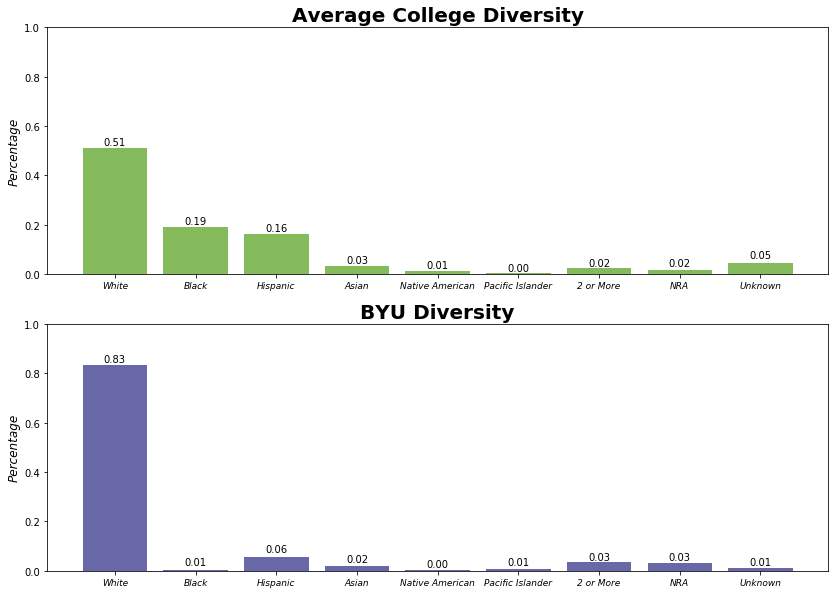

In [23]:
x_nobyu = no_byu.index.values
y_nobyu = no_byu.values
x_byu = byu.index.values
y_byu = byu.values

text_kwargs = dict(family='sans-serif', fontsize=12, fontstyle='italic')

y_lim = 1

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(14, 10))

ax1.bar(x_nobyu, y_nobyu, color='#84BA5B', width=.8)
ax1.set_ylim(0, y_lim)
for x_coord, y_coord in zip(x_nobyu, ['%.2f' % x for x in y_nobyu]):
    ax1.text(x_coord, float(y_coord) + .015, y_coord, ha='center')
ax1.set_xticklabels(list(x_nobyu), family='sans-serif', fontsize=9, fontstyle='italic')
ax1.set_ylabel('Percentage', **text_kwargs)
ax1.set_title('Average College Diversity', fontsize=20, fontweight='bold')

ax2.bar(x_byu, y_byu, color='#6867A7', width=.8)
ax2.set_ylim(0, y_lim)
for x_coord, y_coord in zip(x_byu, ['%.2f' % x for x in y_byu]):
    ax2.text(x_coord, float(y_coord) + .015, y_coord, ha='center')
ax2.set_xticklabels(list(x_byu), family='sans-serif', fontsize=9, fontstyle='italic')
ax2.set_ylabel('Percentage', **text_kwargs)
ax2.set_title('BYU Diversity', fontsize=20, fontweight='bold')

fig;

##### It looks like BYU comes in really low in the black and hispanic department, while having a lot more whites. The rest look statistically similar, although more testing would better verify that claim.

# Data Source: API (*Do not run again-- token is not included*)

#### This data comes from BYU's Handshake server, which hosts data on all the recruiting events that occur through BYU. I have access due to my job, where I make use of this API to publish reports that my stakeholders need.

##### We'll start by making the API call. The API will only return 50 events at a time, and I know we have thousands of events in Handshake. I want to get all of them. So I'll do this by creating an API call that safely gets all events and the corresponding information I want into a nested list, and from there, I'll be able to plug it into a dataframe object.

In [24]:
with open('handshake_token.txt', 'r') as f:
    token = f.read()
    
params = {'page': 0,
         'per_page': 50,
         'sort_direction': 'desc',
         'sort_column': 'start_date'}
    
headers = {
        'Authorization': 'Token token="{}"'.format(token),
        'Content-Type': 'application/json',
        'Cache-Control': 'no-cache--url',
    }
url = 'https://app.joinhandshake.com/api/v1/events'

all_events = []

while True:
    r = requests.get(url, params=params, headers=headers)
    if r.status_code != 200:
        continue
    if (r.json())['success'] != True:
        continue
    events = (r.json())['events']
    if len(events) == 0:
        break
    for event in events:
        single_event = []
        single_event.append(event['id'])
        single_event.append(event['name'])
        single_event.append(event['status'])
        single_event.append(event['invite_only'])
        single_event.append(event['start_date'])
        single_event.append(event['event_type']['name'])
        all_events.append(single_event)
    params['page'] += 1

##### Let's plug it all into a DataFrame and see what we got.

In [25]:
events = pd.DataFrame(all_events, columns=['ID', 'Name', 'Status', 'Invite Only', 'Start Date', 'Event Type'])
events.head()

,ID,Name,Status,Invite Only,Start Date,Event Type
0,269658,ExDS- Professional Development Night w/ Impact...,pending,False,2019-02-06T02:30:00.000Z,Other
1,269589,IM Flash Interviews,pending,False,2019-02-09T03:00:00.000Z,Other
2,269565,UGF Summer Internship Recruiting Booth,pending,False,2019-02-07T16:00:00.000Z,Other
3,269290,Southwest Office Hours: (Internship; Accounti...,approved,True,2019-02-06T19:00:00.000Z,Other
4,269167,CP - Justin Jones,approved,True,2019-02-06T20:00:00.000Z,Classroom Presentation


##### Now I want to think about filtering. I think I'm going to do this on `Event Type` first. Let's look at each unique value found in the series and how many entries it has.

In [26]:
events['Event Type'].value_counts()

Info Session              4195
Other                      729
Classroom Presentation     175
Employer On-site            86
Workshop                    75
Networking                  48
Speaker/Panel               39
Group Appointment            9
Name: Event Type, dtype: int64

##### I'll filter down later. Let's look at the same thing for `Status`.

In [27]:
events['Status'].value_counts()

approved    5016
declined     297
pending       43
Name: Status, dtype: int64

##### Now `Invite Only`.

In [28]:
events['Invite Only'].value_counts()

False    5094
True      262
Name: Invite Only, dtype: int64

##### I know how I want to filter down the data. I'm interested in keeping events that are open to all students. Anything that seems private (or not explicitly public) is a goner. So I'm going to use boolean masking to drop events of the type `Group Appointment` and `Other`. For `Status`, I only want events that are `approved`. If they are `declined` or `pending`, they didn't/won't happen. I'm not interested in those. Lastly, any event that is `Invite Only` isn't open to the public, so those got to go too.

In [29]:
events = events[(events['Event Type'] != 'Group Appointment') & (events['Event Type'] != 'Other')]
events = events[events['Status'] == 'approved']
events = events[events['Invite Only'] == False]
events.head()

,ID,Name,Status,Invite Only,Start Date,Event Type
11,268878,Career Bootcamp,approved,False,2019-03-28T23:00:00.000Z,Workshop
12,268876,Education Career Fair Prep (Teacher Fair Prep),approved,False,2019-03-14T23:00:00.000Z,Workshop
15,268816,Secondary Education Lunch Panel,approved,False,2019-02-28T18:00:00.000Z,Workshop
16,268807,Special Education Lunch Panel,approved,False,2019-02-14T18:00:00.000Z,Workshop
17,268799,Elementary Education Lunch Panel,approved,False,2019-01-31T18:00:00.000Z,Workshop


##### Looking at the series `Start Date`, I immediately see that it's returning to me strings that are datetimes in UTC (Coordinated Universal Time). I need to get these into datetime objects in Mountain Time so I don't have events spilling over into other days (which is particuarlly worrisome if the event occurs in the evening, since UTC is later than Mountain Time). Once I have them into datetime, I want to aggregate them by date, so I'll call the `.date` attribute of the datetime object to get the date back in each case.

In [30]:
events['Start Date'] = events['Start Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
events['Start Date'] = events['Start Date'].dt.tz_localize('UTC')
events['Start Date'] = events['Start Date'].dt.tz_convert(pytz.timezone('US/Mountain'))
events['Start Date'] = events['Start Date'].apply(lambda x: x.date())
events['Start Date'].head()

11    2019-03-28
12    2019-03-14
15    2019-02-28
16    2019-02-14
17    2019-01-31
Name: Start Date, dtype: object

##### Here's an issue. Some dates don't have events on them, but I still want those dates to show up as having no events. I need to create a pandas datetimeindex and fill any dates that don't have any events on them with zeros.

In [31]:
info = events['Start Date'].value_counts().sort_index()
dt_index = pd.date_range(start=info.index[0], end=info.index[-1])
info.index = pd.DatetimeIndex(info.index)
info = info.reindex(dt_index, fill_value=0)
info.rename('Event Counts', inplace=True)
info.head(10)

2014-04-01    1
2014-04-02    0
2014-04-03    1
2014-04-04    0
2014-04-05    0
2014-04-06    0
2014-04-07    0
2014-04-08    0
2014-04-09    1
2014-04-10    0
Freq: D, Name: Event Counts, dtype: int64

##### I'm curious to see if there are any cyclical patterns, so let's see if we can group these counts together by month and see counts for each month to effectively say what months have the most recruiting events.

In [32]:
info.groupby(pd.Grouper(freq='m')).sum().sort_values(ascending=False).head(10)

2016-09-30    361
2017-09-30    305
2017-10-31    226
2015-09-30    224
2016-10-31    185
2018-02-28    183
2018-03-31    182
2018-09-30    168
2017-02-28    160
2014-09-30    149
Name: Event Counts, dtype: int64

##### It looks like September of 2016 had the most events! At least in the top ten event counts, it looks like the months are fairly reoccuring, namely, September, October, February, March.

##### Now, let's describe the data some more. I'm curious if event counts are correlated with certain days of the week.

In [33]:
info_frame = info.to_frame()
info_frame['Weekday'] = [x.weekday() for x in info_frame.index]
info_frame['Weekday'] = info_frame['Weekday'].map({0: 'Monday',
                                                   1: 'Tuesday',
                                                   2: 'Wednesday',
                                                   3: 'Thursday',
                                                   4: 'Friday',
                                                   5: 'Saturday',
                                                   6: 'Sunday'})
for day in info_frame['Weekday'].unique():
    info_frame[day] = info_frame['Weekday'].str.contains(day)
    
info_frame.drop('Weekday', axis=1).corr()['Event Counts']

Event Counts    1.000000
Tuesday         0.136339
Wednesday       0.133178
Thursday        0.227511
Friday         -0.062473
Saturday       -0.175175
Sunday         -0.188787
Monday         -0.071021
Name: Event Counts, dtype: float64

##### That's interesting! High event counts are most correlated with Thursday. My coworkers that need to host those events on Thursdays may benefit from being better prepared.

##### Great. Anyway,  I have a series `info` where the index is the date, and the number is the amount of events that occured on that date. I can use that to move onto plotting now.

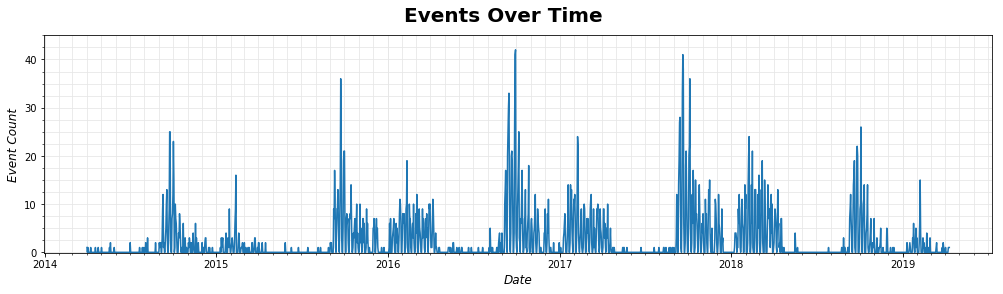

In [34]:
counts = info.values
dates = info.index.map(mdates.date2num).values

text_kwargs = dict(family='sans-serif', fontsize=12, fontstyle='italic')

years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')
count_fmt = ticker.AutoMinorLocator(n=4)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 4))
ax.plot(dates, counts)
ax.grid(which='both', color='.9')

ax.set_ylim(bottom=-.1, top=45)

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.yaxis.set_minor_locator(count_fmt)

ax.set_xlabel('Date', **text_kwargs)
ax.set_ylabel('Event Count', **text_kwargs)
fig.suptitle('Events Over Time', fontsize=20, fontweight='bold')

fig;

##### It looks like event hosting is cyclical, meaning that there is a large spike of events in September and October, at the beginning of the Fall semester, and then there is another smaller spike in February and March. It looks like almost no events go on during the Spring and Summer terms. That could be useful information for my stakeholders!